# Integrating ODEs using `solve_ivp`

First, import some stuff we'll need. We give some of them nicknames to save typing later

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

The function `solve_ivp`, which is found in the `integrate` submodule of the `scipy` package, solves initial value problems (IVPs) by integrating ordinary differential equations of the form
$$
\newcommand{\yy}{\mathbf{y}}
\newcommand{\ff}{\mathbf{f}}
\frac{\mathrm{d} \yy}{\mathrm{d}t} = \ff(t,\yy),
$$where $\yy$ is a vector in $\mathbb{R}^n$, or
$$
\dot{\yy} =  \ff(t, \yy).
$$
That is, it provides a numerical solution of the *initial value problem* given by this differential equation, together with an initial condition
$$
\yy(t = t_0) = \yy_0,
$$
returning the solution curve (or trajectory) $\yy(t)$ as a function of time $t$, within a certain (finite!) range of values of $t$.

Writing $\yy = (y_1, \ldots, y_n)$, we have a system of the form
\begin{align}
\dot{y_1} &= f_1(y_1, \ldots, y_n, t) \\
\dot{y_2} &= f_2(y_1, \ldots, y_n, t) \\
&\ldots \\
\dot{y_n} &= f_n(y_1, \ldots, y_n, t)
\end{align}

Note that in fact, *any* ordinary (system of) ordinary differential equation(s) can be written in this form by defining new variables to represent higher-order derivatives,  
and incorporating them into the vector $\yy$ of variables.

To use `solve_ivp`, we must define at least the Python function `f` which implements the mathematical function $\ff$. It must take a time `t` (even if it doesn't use it) and a vector `y`,
and return the new vector `f(t,y)`.

If you only have a single first-order ODE, you can use `solve_ivp` by defining a function `f` that takes `t` and a single value `y`, and returns a single value `f(t,y)` (a special case of a vector with length 1)

> Note: `solve_ivp` is a relatively new function in scipy. Previously, the function `odeint` was used for this purpose, but it is now deprecated. If you find instructions for using `odeint`, the main difference is the order of the arguments to the function `f` was `f(y,t)` (which is the opposite of the order used by `solve_ivp`).

## 1D equations

The simplest case is when the spatial dimension is $n=1$. For example, we could wish to solve the ODE
$
\dot{y} = ay,
$
whose exact solution is, of course, $y(t) = y_0 \exp(a t)$.

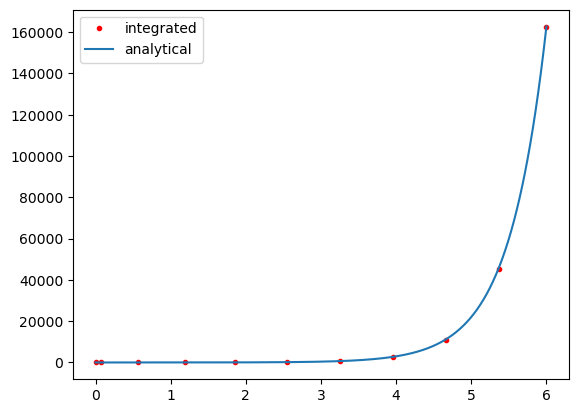

It used 11 time points, and got 162653.0465733635 at t=6.0
The exact solution at t=6.0 is 162754.79141900392
which is an absolute error of -101.74484564040904 or relative error of -6.25e-04


In [15]:
a = 2.0

def f(t, y):
    "The right hand side of our differential equation, dy/dt = a*y"
    return a * y


# initial value
y0 = [1.0]  # must be a list or "array-like" object, even if it's just one value.

# Time span (start and end)
t_span = (0, 6)

# Letting the solver choose the time points:
solution = solve_ivp(f, t_span, y0)

y_output = solution.y[0]
times = solution.t
plt.plot(times, y_output, "r.", label="integrated")

many_times = np.linspace(t_span[0], t_span[1], 1000) # to make a smooth curve
y_exact = y0 * np.exp(a * many_times)  # analytical solution
plt.plot(many_times, y_exact, label="analytical")
plt.legend()
plt.show()

print(f"It used {len(times)} time points, and got {y_output[-1]} at t={times[-1]}")
print(f"The exact solution at t={times[-1]} is {y_exact[-1]}")
print(f"which is an absolute error of {y_output[-1] - y_exact[-1]} or relative error of {(y_output[-1] - y_exact[-1])/y_exact[-1]:.2e}")

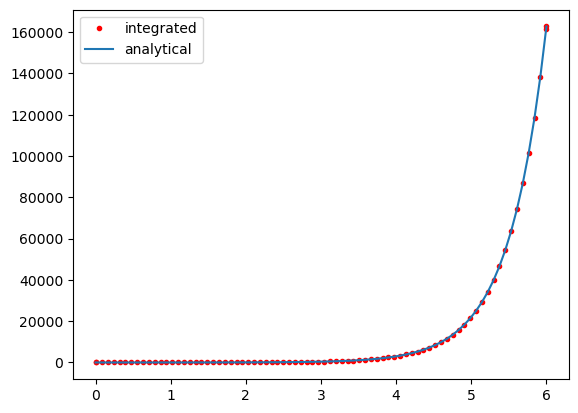

It used 80 time points, and got 162754.82871291912 at t=6.0
The exact solution at t=6.0 is 162754.79141900392
which is an absolute error of 0.037293915200280026 or relative error 2.29e-07


In [16]:
# Letting the solver choose the time points,
# but requesting a tighter (more accurate) tolerances.
# rtol is the relative tolerance, and atol is the absolute tolerance.
solution = solve_ivp(f, t_span, y0, rtol=1e-7, atol=1e-9)  # try changing these...

y_output = solution.y[0]
times = solution.t
y_exact = y0 * np.exp(a * times)
plt.plot(times, y_output, "r.", label="integrated")
plt.plot(times, y_exact, label="analytical")
plt.legend()
plt.show()

print(f"It used {len(times)} time points, and got {y_output[-1]} at t={times[-1]}")
print(f"The exact solution at t={times[-1]} is {y_exact[-1]}")
print(f"which is an absolute error of {y_output[-1] - y_exact[-1]} or relative error {(y_output[-1] - y_exact[-1])/y_exact[-1]:.2e}")

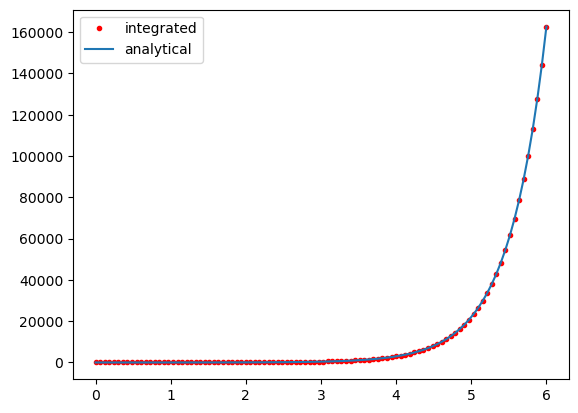

It used 100 time points, and got 162653.04657336365 at t=6.0
The exact solution at t=6.0 is 162754.79141900392
which is an error of -101.74484564026352 or -6.25e-04


In [17]:
times = np.linspace(0, 6, 100)  # specify 50 timepoints

solution = solve_ivp(f, t_span, y0, t_eval=times)
y_output = solution.y[0]
y_exact = y0 * np.exp(a * times)
plt.plot(times, y_output, "r.", label="integrated")
plt.plot(times, y_exact, label="analytical")
plt.legend()
plt.show()

print(f"It used {len(times)} time points, and got {y_output[-1]} at t={times[-1]}")
print(f"The exact solution at t={times[-1]} is {y_exact[-1]}")
print(f"which is an error of {y_output[-1] - y_exact[-1]} or {(y_output[-1] - y_exact[-1])/y_exact[-1]:.2e}")

Even though we forced it to solve at more time points, it didn't get more accurate. The best way to control accuracy is with the `rtol` and `atol` parameters. 

>Unfortunately the default values are not always precise enough for chemical kinetics, so it is always worth checking the results with different values of `rtol` and `atol`.

# Example E5-7, Calculating X in a reactor with pressure drop
Please read page 194-199 in the textbook "Essentials of Chemical Reaction Engineering" (2nd Edition) by Fogler.
Instead of using Polymath or MATLAB, we'll use `solve_ivp`.

This time we have two variables to integrate (conversion $X$ and pressure ratio $p$), so our function must accept and return a vector of length 2. We integrate over weight of catalyst $W$, not time $t$.
The differential equations are:

$$\frac{\mathrm{d} X}{\mathrm{d} W} = \frac{-r_A'}{F_{A0}}  \tag{E5-7.9}$$
$$\frac{\mathrm{d} p}{\mathrm{d} W} = -\alpha \frac{(1+\epsilon X)}{2p} \tag{E5-7.10}$$

(there's a typo in the textbook, the second equation used $dy$ instead of $dp$)


In [18]:
def dYvecdV(W, Yvec):
    """
    This function returns the right-hand side of the differential equations.
    Accepts two arguments: W is the independent variable (not used here),
    and Yvec is a vector of dependent variables [X, p].
    """
    X, p = Yvec  # unpack values from Y vector into two variables
    # Explicit equations
    epsilon = -0.15
    kprime = 0.0074
    Fa0 = 0.1362
    alpha = 0.0367
    raprime = -1 * kprime * (1 - X) / (1 + epsilon * X) * p

    # Differential equations
    dXdW = -raprime / Fa0
    dydW = -1 * alpha * (1 + epsilon * X) / (2 * p)
    # pack up the two differential equations into the dYvecdV vector
    return [dXdW, dydW]

Set up the steps you want to integrate over. In this case it's Weight not Time.


In [19]:
# Places we want to know the solution, in the independent variable
# (weight of catalyst of the reactor
W_output = np.linspace(0, 27.0, 28)
print(W_output)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.]


In [20]:
# Look at the shape of the array.
# In this case, it's a 1D array with 28 elements.
print(W_output.shape)

(28,)


Set up the initial conditions, as a vector of the two values

In [21]:
Y0 = [0.0, 1.0]  # Initial values for the dependent variables i.e X and p

Perform the integration, and extract the results

In [22]:
solution = solve_ivp(dYvecdV, (0, 27), Y0, t_eval=W_output, rtol=1e-6, atol=1e-9)
Y_result = solution.y
print(Y_result.shape)

(2, 28)


In [23]:
# You could extract the results for X and p from the Y_result array like this
X = Y_result[0]
p = Y_result[1]
print(W_output.shape, X.shape, p.shape)

(28,) (28,) (28,)


In [24]:
# Or you could do it like this
X, p = Y_result
print(W_output.shape, X.shape, p.shape)

(28,) (28,) (28,)


In [25]:
epsilon = -0.15
f = (1 + epsilon * X) / p  # volumetric flow rate ratio
f

array([1.        , 1.01075349, 1.02265479, 1.03577345, 1.05019073,
       1.06600165, 1.08331757, 1.10226956, 1.12301246, 1.14572994,
       1.17064057, 1.1980071 , 1.22814822, 1.26145227, 1.29840116,
       1.33958301, 1.38574939, 1.4378755 , 1.49723681, 1.5655212 ,
       1.64504568, 1.73908565, 1.8524889 , 1.99270644, 2.17191455,
       2.41202055, 2.75697424, 3.31402448])

Now we can plot the results

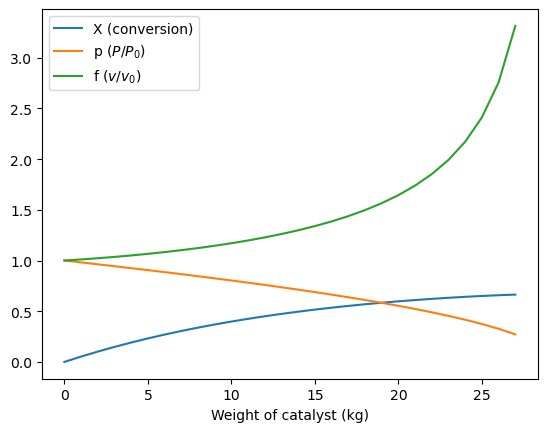

In [26]:
plt.plot(W_output, X, label="X (conversion)")
plt.plot(W_output, p, label="p ($P/P_0$)")
plt.plot(W_output, f, label="f ($v/v_0$)")
plt.legend(loc="upper left")
plt.xlabel("Weight of catalyst (kg)")

plt.show()

# Integrating other variables
Sometimes it's convenient to integrate things like $N_{tot}$ or Volume, that maybe are just used as intermediate values in your calculations, as well as the variables that you think you care most about. Just add them to your vector.